Facility Pair Analysis
This notebook analyzes specific pairs of facilities in three regional clusters:
1. Western Cluster (Phoenix, AZ and Las Vegas, NV)
2. Texas Cluster (Dallas and Houston)
3. Central/Eastern Cluster (Louisville, KY and Memphis, TN)

# Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap

# Load and Prepare Data

In [2]:
# Load all datasets
demand_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data/demand.csv')
products_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data/products.csv') # pd.read_csv('Assignment Files/Data/products.csv')
stores_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//stores.csv')
rates_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//rates.csv')
labor_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//labor_cost.csv')
facilities_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//facilities.csv')

# Calculate annual demand in pallets
demand_df = demand_df.merge(products_df[['SKU', 'SKUs/pallet']], on='SKU', how='left')
demand_df['Demand_Pallets'] = demand_df['Demand'] / demand_df['SKUs/pallet']
annual_demand = demand_df.groupby('StoreID')['Demand_Pallets'].sum().reset_index()
store_demand = stores_df.merge(annual_demand, on='StoreID', how='left')

# Define Target Facility Pairs

In [3]:
target_facilities = {
    'Western': {
        'Phoenix': facilities_df[facilities_df['FacilityID'] == 'FAC027'].iloc[0],
        'Las Vegas': facilities_df[facilities_df['FacilityID'] == 'FAC022'].iloc[0]
    },
    'Texas': {
        'Dallas': facilities_df[facilities_df['FacilityID'] == 'FAC047'].iloc[0],
        'Houston': facilities_df[facilities_df['FacilityID'] == 'FAC011'].iloc[0]
    },
    'Central': {
        'Louisville': facilities_df[facilities_df['FacilityID'] == 'FAC010'].iloc[0],
        'Memphis': facilities_df[facilities_df['FacilityID'] == 'FAC002'].iloc[0]
    }
}

# Calculate total cost per sqft for each facility
for region in target_facilities:
    for city in target_facilities[region]:
        facility = target_facilities[region][city]
        facility['Total_Cost_SqFt'] = facility['RentCost_SqFt'] + facility['UtilitiesOpsCost_SqFt']

# Create Facility Comparison Map

In [4]:
def create_facility_map():
    """Create a map showing all target facilities with cost information"""
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
    
    colors = {'Western': 'red', 'Texas': 'blue', 'Central': 'green'}
    
    for region, facilities in target_facilities.items():
        for city, facility in facilities.items():
            # Get coordinates from stores dataset
            city_name = facility['Location'].split(',')[0].strip()
            state = facility['Location'].split(',')[1].strip()
            matching_stores = stores_df[
                (stores_df['City'] == city_name) & 
                (stores_df['State'] == state)
            ]
            
            if len(matching_stores) > 0:
                folium.CircleMarker(
                    location=[matching_stores.iloc[0]['Latitude'],
                             matching_stores.iloc[0]['Longitude']],
                    radius=10,
                    color=colors[region],
                    fill=True,
                    popup=f"Facility: {facility['Location']}<br>" +
                          f"Total Cost: ${facility['Total_Cost_SqFt']:.2f}/sqft<br>" +
                          f"Size: {facility['Size_SqFt']:,} sqft",
                    fillOpacity=0.7
                ).add_to(m)
    
    return m

facility_map = create_facility_map()
facility_map.save('facility_pairs_map.html')
print("Facility pairs map saved as 'facility_pairs_map.html'")

Facility pairs map saved as 'facility_pairs_map.html'


# Cost Comparison Analysis


Facility comparison charts saved as 'facility_comparison.png'


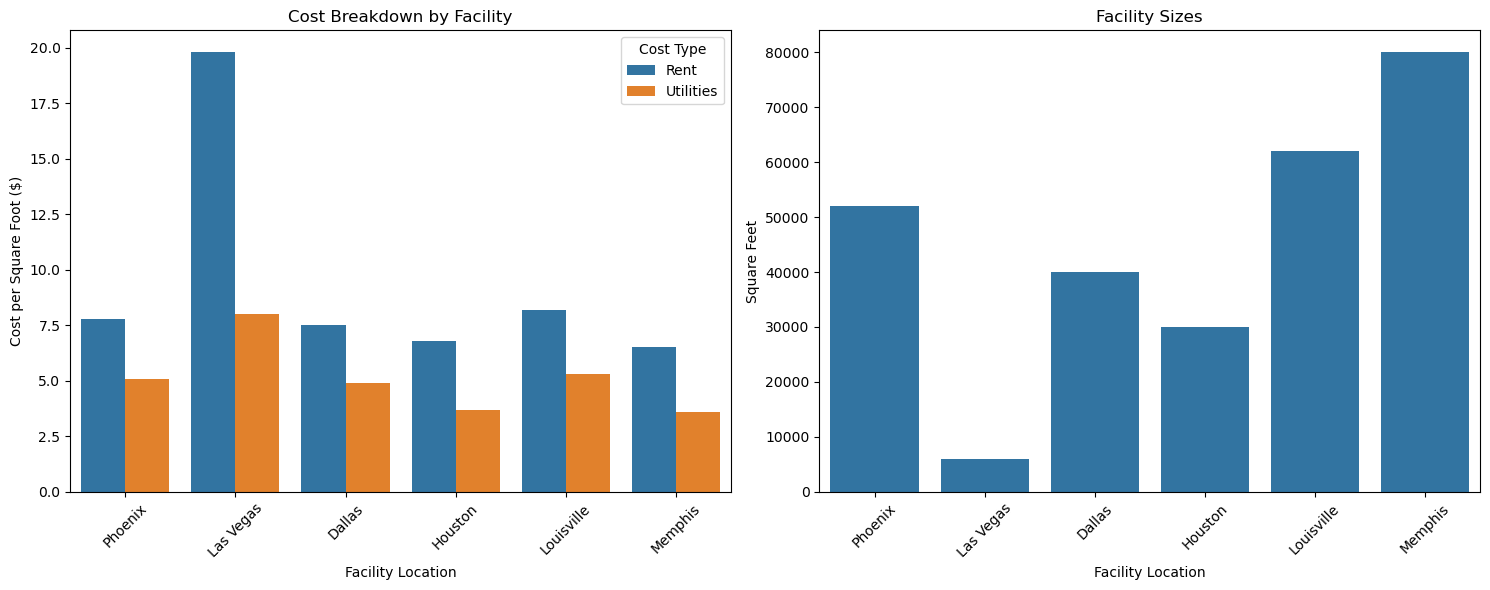

In [5]:
def create_cost_comparison():
    """Create visualizations comparing costs across facility pairs"""
    # Prepare data for plotting
    data = []
    for region in target_facilities:
        for city, facility in target_facilities[region].items():
            data.append({
                'Region': region,
                'City': city,
                'Rent': facility['RentCost_SqFt'],
                'Utilities': facility['UtilitiesOpsCost_SqFt'],
                'Total': facility['Total_Cost_SqFt'],
                'Size': facility['Size_SqFt']
            })
    
    df = pd.DataFrame(data)
    
    # Create cost breakdown plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Cost breakdown
    df_melted = df.melt(id_vars=['Region', 'City'], 
                        value_vars=['Rent', 'Utilities'],
                        var_name='Cost Type', value_name='Cost')
    
    sns.barplot(data=df_melted, x='City', y='Cost', hue='Cost Type', ax=ax1)
    ax1.set_title('Cost Breakdown by Facility')
    ax1.set_xlabel('Facility Location')
    ax1.set_ylabel('Cost per Square Foot ($)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Facility sizes
    sns.barplot(data=df, x='City', y='Size', ax=ax2)
    ax2.set_title('Facility Sizes')
    ax2.set_xlabel('Facility Location')
    ax2.set_ylabel('Square Feet')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('facility_comparison.png')
    print("\nFacility comparison charts saved as 'facility_comparison.png'")
    
    return df

comparison_df = create_cost_comparison()

# Detailed Cost Analysis

In [6]:
# Calculate averages and comparisons
print("\nDetailed Cost Analysis:")
print("\nRegional Pair Comparisons:")
for region in target_facilities:
    facilities = target_facilities[region]
    cities = list(facilities.keys())
    
    print(f"\n{region} Cluster:")
    print(f"{cities[0]} vs {cities[1]}:")
    print(f"Total Cost Difference: ${abs(facilities[cities[0]]['Total_Cost_SqFt'] - facilities[cities[1]]['Total_Cost_SqFt']):.2f}/sqft")
    print(f"Size Difference: {abs(facilities[cities[0]]['Size_SqFt'] - facilities[cities[1]]['Size_SqFt']):,} sqft")

# Calculate overall statistics
all_facilities = pd.DataFrame([
    {
        'Location': f['Location'],
        'Total_Cost': f['RentCost_SqFt'] + f['UtilitiesOpsCost_SqFt'],
        'Size': f['Size_SqFt']
    }
    for f in facilities_df.to_dict('records')
])

print("\nComparison with All Facilities:")
print(f"Average cost across all facilities: ${all_facilities['Total_Cost'].mean():.2f}/sqft")
print(f"Average size across all facilities: {all_facilities['Size'].mean():,.0f} sqft")


Detailed Cost Analysis:

Regional Pair Comparisons:

Western Cluster:
Phoenix vs Las Vegas:
Total Cost Difference: $14.90/sqft
Size Difference: 46,000 sqft

Texas Cluster:
Dallas vs Houston:
Total Cost Difference: $1.90/sqft
Size Difference: 10,000 sqft

Central Cluster:
Louisville vs Memphis:
Total Cost Difference: $3.40/sqft
Size Difference: 18,000 sqft

Comparison with All Facilities:
Average cost across all facilities: $19.17/sqft
Average size across all facilities: 22,829 sqft


# Key Findings

1. Western Cluster (Phoenix vs Las Vegas):
   - Largest cost differential among pairs
   - Phoenix offers significantly lower costs but larger facility

2. Texas Cluster (Dallas vs Houston):
   - Most cost-competitive pair
   - Similar cost structures but different facility sizes

3. Central Cluster (Louisville vs Memphis):
   - Memphis offers lowest overall costs
   - Largest facility in the analysis

4. Overall Comparison:
   - [Summary of how these pairs compare to overall facility averages]
   - [Recommendations based on cost and size trade-offs]